# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [1]:
import numpy as np
import scipy as sp
import tensorflow as tf
import matplotlib.image as mpimg
import sklearn.preprocessing as pp
import random
import cv2
import matplotlib.pyplot as plt
import csv
%matplotlib inline 

---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = './train.p'
testing_file = './test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# TODO: Number of training examples
n_train = len(X_train)

# TODO: Number of testing examples.
n_test = len(X_test)

# TODO: What's the shape of an traffic sign image?
image_shape = X_test[58].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_train))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

2:   Speed limit (50km/h)


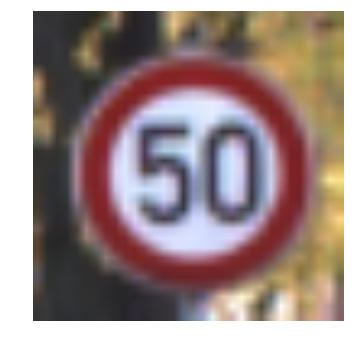

________________________________________________________________ 



23:   Slippery road


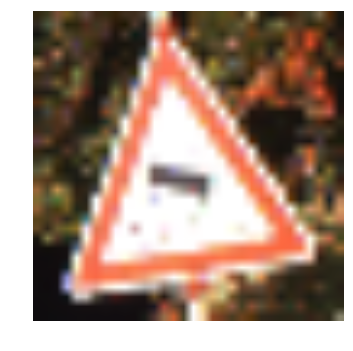

________________________________________________________________ 



17:   No entry


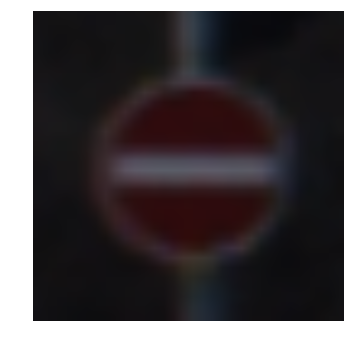

________________________________________________________________ 



9:   No passing


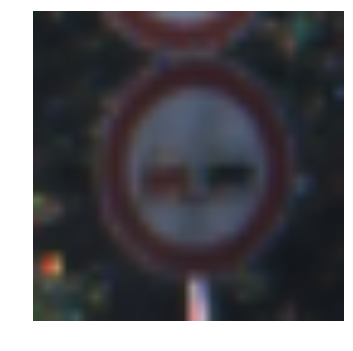

________________________________________________________________ 



38:   Keep right


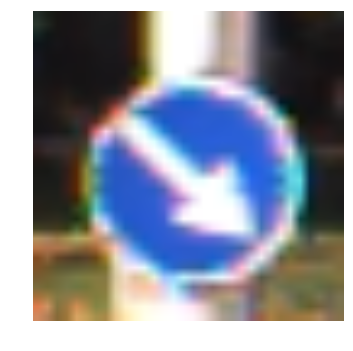

________________________________________________________________ 



38:   Keep right


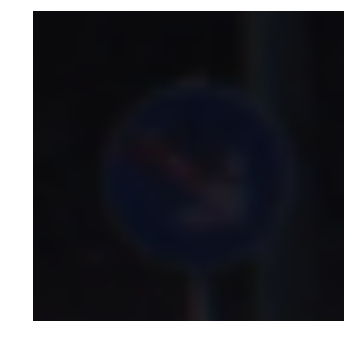

________________________________________________________________ 



17:   No entry


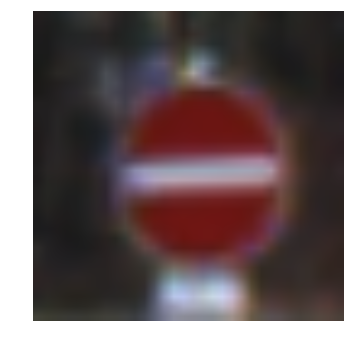

________________________________________________________________ 



1:   Speed limit (30km/h)


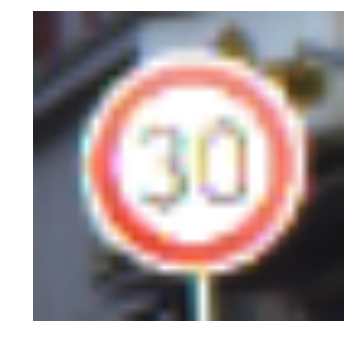

________________________________________________________________ 



17:   No entry


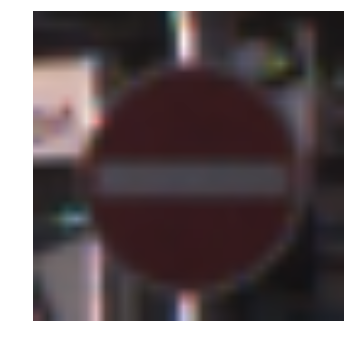

________________________________________________________________ 



12:   Priority road


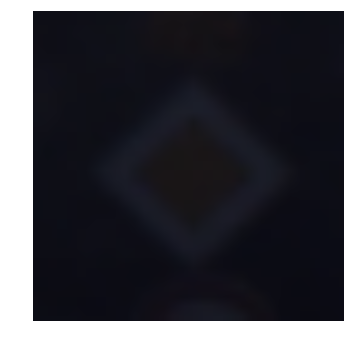

________________________________________________________________ 





In [5]:
""" First, let's take a look at some of the images and what their labels look like: """

sign_names = {}
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         sign_names[row[0]] = row[1]


for i in np.random.permutation(len(X_train))[:10]:
    print(str(y_train[i]) + ":   "+sign_names[str(y_train[i])])
    plt.imshow(X_train[i])
    plt.axis('off')
    plt.show()
    print("________________________________________________________________ \n\n\n")

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

##### Preprocessing

In [6]:
def rgb_to_normalized_gray(rgb):
    #gray = cv2.cvtColor(rgb, cv2.COLOR_BGR2GRAY)
    r, g, b = rgb[:,:,0], rgb[:,:,1], rgb[:,:,2]
    gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
    return gray/255. - 0.5

def normalize(imgs):
    imgs = np.array(imgs, dtype=np.float64)
    return imgs/255. - 0.5

In [7]:
X_train_batches = []
y_train_batches = []

perm = np.random.permutation(len(X_train))[:40*980]
perm = perm.reshape((40,980))

images = normalize(X_train)

for j in range(40):
    x_train_batch = images[perm[j]]
    y_train_batch = y_train[perm[j]]
    
    X_train_batches.append(x_train_batch)
    y_train_batches.append(y_train_batch)

In [8]:
X_test_batch =  normalize(X_test)

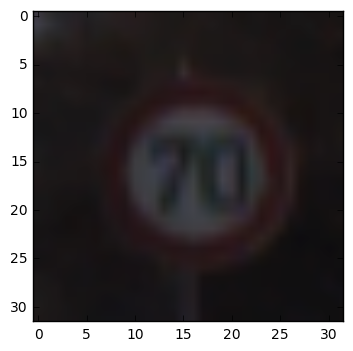

In [9]:
plt.imshow(X_test_batch[20]+0.5)

##### Data Augmentation (credit: Vivek Yadav)

In [10]:
def transform_image(img,ang_range,shear_range,trans_range, reduction_coeff):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over. 
    
    A Random uniform distribution is used to generate different parameters for transformation
    
    '''
    ang_range*=reduction_coeff
    shear_range*=reduction_coeff
    trans_range*=reduction_coeff
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols, colours = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)
        
    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))
    
    value = np.random.uniform(high=100.) - 50
    value*=reduction_coeff
    coef = 1
    if value < -1:
        coef = -1
        value = abs(value)
        
    value = np.array(value, dtype=np.uint8)
    
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) #convert it to hsv
    if coef == 1:
        hsv[:,:,2] = np.where((255 - hsv[:,:,2]) < value,255,hsv[:,:,2]+value)
    else:
        hsv[:,:,2] = np.where( hsv[:,:,2] < value,0,hsv[:,:,2]-value)
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    
    return img

### Network Architecture

###### Parameters

In [11]:
n_input = 32*32*3 # Traffic Signs data input (img shape)
n_classes = 43 # Traffic Signs total classes (43 different types of signs)
dropout = 0.5 # Dropout

###### Tensorflow Graph Input

In [73]:
tf.reset_default_graph()
x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = tf.placeholder(tf.float32, [None, n_classes])
keep_prob = tf.placeholder(tf.float32) # dropout (keep probability)

###### AlexNet Model

In [74]:
def conv2d(name, l_input, w, b):
    return tf.nn.elu(tf.nn.bias_add(tf.nn.conv2d(l_input, w, strides=[1, 1, 1, 1], 
                                                  padding='SAME'),b), name=name)

def max_pool(name, l_input, k):
    return tf.nn.max_pool(l_input, ksize=[1, k, k, 1], strides=[1, k, k, 1], 
                          padding='SAME', name=name)

def norm(name, l_input, lsize=4):
    return tf.nn.lrn(l_input, lsize, bias=1.0, alpha=0.001 / 9.0, beta=0.75, name=name)

def alex_net(_X, _weights, _biases, _dropout):
    # Reshape input picture
    _X = tf.reshape(_X, shape=[-1, 32, 32, 3])

    # Convolution Layer
    conv1 = conv2d('conv1', _X, _weights['wc1'], _biases['bc1'])
    # Max Pooling (down-sampling)
    pool1 = max_pool('pool1', conv1, k=3)
    # Apply Normalization
    norm1 = norm('norm1', pool1, lsize=4)
    # Apply Dropout
    norm1 = tf.nn.dropout(norm1, _dropout)

    # Convolution Layer
    conv2 = conv2d('conv2', norm1, _weights['wc2'], _biases['bc2'])
    # Max Pooling (down-sampling)
    pool2 = max_pool('pool2', conv2, k=3)
    # Apply Normalization
    norm2 = norm('norm2', pool2, lsize=4)
    # Apply Dropout
    norm2 = tf.nn.dropout(norm2, _dropout)

    # Convolution Layer
    conv3 = conv2d('conv3', norm2, _weights['wc3'], _biases['bc3'])
    # Max Pooling (down-sampling)
    pool3 = max_pool('pool3', conv3, k=3)
    # Apply Normalization
    norm3 = norm('norm3', pool3, lsize=4)
    # Apply Dropout
    norm3 = tf.nn.dropout(norm3, _dropout)

    # Fully connected layer
    # Reshape conv3 output to fit dense layer input
    
    #flat1 = tf.reshape(norm1, [-1]) 
    #flat2 = tf.reshape(norm2, [-1])
    #flat3 = tf.reshape(norm3, [-1])
    
    #concat = tf.concat(0, [flat1, flat2, flat3])
    #dense1 = tf.reshape(concat, [-1, _weights['wd1'].get_shape().as_list()[0]])
    
    
    dense1 = tf.reshape(norm3, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    
    
    #dense1 = tf.reshape(norm2, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    #dense1 = tf.reshape(norm1, [-1, _weights['wd1'].get_shape().as_list()[0]]) 
    
    
    # Relu activation
    dense1 = tf.nn.elu(tf.matmul(dense1, _weights['wd1']) + _biases['bd1'], name='fc1')
    dense1 = tf.nn.dropout(dense1, _dropout)
    
    dense2 = tf.nn.elu(tf.matmul(dense1, _weights['wd2']), name='fc2')
    dense2 = dense2  + _biases['bd2']
    dense2 = tf.nn.dropout(dense2, _dropout)
    # Output, class prediction
    #out = tf.matmul(dense2, _weights['out']) + _biases['out']
    out = tf.matmul(dense2, _weights['out']) + _biases['out']
    return out

###### Weights & Biases

In [75]:
weights = {
    'wc1': tf.get_variable("conv1_w", shape=[3, 3, 3, 32], initializer=tf.contrib.layers.xavier_initializer()),
    'wc2': tf.get_variable("conv2_w", shape=[3, 3, 32, 64], initializer=tf.contrib.layers.xavier_initializer()),
    'wc3': tf.get_variable("conv3_w", shape=[3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer()),
    #'wd1': tf.get_variable("dense1_w", shape=[13*13*128/4, 1024], initializer=tf.contrib.layers.xavier_initializer()),
    
    'wd1': tf.get_variable("dense1_w", shape=[512, 1024], initializer=tf.contrib.layers.xavier_initializer()),
    'wd2': tf.get_variable("dense2_w", shape=[1024, 1024], initializer=tf.contrib.layers.xavier_initializer()),
    
    'out': tf.get_variable("out_w", shape=[1024, n_classes], initializer=tf.contrib.layers.xavier_initializer())
}
    
biases = {
    'bc1': tf.get_variable("conv1_b", shape=[32], initializer=tf.contrib.layers.xavier_initializer()),
    'bc2': tf.get_variable("conv2_b", shape=[64], initializer=tf.contrib.layers.xavier_initializer()),
    'bc3': tf.get_variable("conv3_b", shape=[128], initializer=tf.contrib.layers.xavier_initializer()),
    
    'bd1': tf.get_variable("dense1_b", shape=[1024], initializer=tf.contrib.layers.xavier_initializer()),
    'bd2': tf.get_variable("dense2_b", shape=[1024], initializer=tf.contrib.layers.xavier_initializer()),
    
    'out': tf.get_variable("out_b", shape=[n_classes], initializer=tf.contrib.layers.xavier_initializer())
}

### Training

###### Model Construction

In [76]:
model_output = alex_net(x, weights, biases, keep_prob)

###### Loss & Optimization

In [77]:
# Parameters
#learning_rate = 0.0001
learning_rate = 0.001

prediction = tf.nn.softmax(model_output)
cross_entropy = -tf.reduce_sum(y * tf.log(prediction + 1e-6), reduction_indices=1)
cost = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

###### Model Evaluation¶

In [78]:
correct_pred = tf.equal(tf.argmax(prediction,1), tf.argmax(y,1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

###### Initialization

In [79]:
init = tf.initialize_all_variables()
sess = tf.Session()
sess.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.
Instructions for updating:
Use `tf.global_variables_initializer` instead.


###### Learn

In [80]:
saver = tf.train.Saver()
saver.restore(sess, "./GrayELU_BrightVar.ckpt")

NotFoundError: Key dense2_b/Adam not found in checkpoint
	 [[Node: save/RestoreV2_27 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_27/tensor_names, save/RestoreV2_27/shape_and_slices)]]
	 [[Node: save/RestoreV2_26/_55 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_344_save/RestoreV2_26", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]

Caused by op 'save/RestoreV2_27', defined at:
  File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/carnd/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 653, in launch_instance
    app.start()
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 162, in start
    super(ZMQIOLoop, self).start()
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/carnd/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-80-2a89e8f6f7e4>", line 1, in <module>
    saver = tf.train.Saver()
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1000, in __init__
    self.build()
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1030, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 624, in build
    restore_sequentially, reshape)
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 361, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 200, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/ops/gen_io_ops.py", line 441, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 759, in apply_op
    op_def=op_def)
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2240, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/carnd/.local/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1128, in __init__
    self._traceback = _extract_stack()

NotFoundError (see above for traceback): Key dense2_b/Adam not found in checkpoint
	 [[Node: save/RestoreV2_27 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_recv_save/Const_0, save/RestoreV2_27/tensor_names, save/RestoreV2_27/shape_and_slices)]]
	 [[Node: save/RestoreV2_26/_55 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/gpu:0", send_device="/job:localhost/replica:0/task:0/cpu:0", send_device_incarnation=1, tensor_name="edge_344_save/RestoreV2_26", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"]()]]


In [81]:
current_X_train_batches = X_train_batches

In [ ]:
for step in range(1000):
    print("Iteration "+str(step))
    if step < 30:
        step = 30
    val = len(X_train_batches)-40*step
    if val <= 0:
        val = 40
    for i in range(val):#len(X_train_batches)-40*step):
        
        # Fit training using batch data
        batch_xs = current_X_train_batches[i]
        batch_ys = tf.one_hot(y_train_batches[i], n_classes).eval(session=sess)
        sess.run(optimizer, feed_dict={x: batch_xs, y: batch_ys, keep_prob: dropout})
        
        acc = sess.run(accuracy, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
        loss = sess.run(cost, feed_dict={x: batch_xs, y: batch_ys, keep_prob: 1.})
        
        print("Batch " + str(i) + ", Minibatch Loss= " \
                  + "{:.6f}".format(loss) + ", Training Accuracy= " + "{:.5f}".format(acc))
    
    if step%10 == 0:
        save_path = saver.save(sess, "./Gray_ELU_BrightVar.ckpt")
        print("Model saved in file: %s" % save_path)
    
    # Augmented data generation:
    reduction_coefficient = 1
    if step > 10:
        reduction_coefficient = 0.9**(step-10)
    current_X_train_batches = normalize([[transform_image(np.array((image+0.5)*255, dtype=np.uint8),10,5,3,reduction_coefficient) for image in batch] for batch in X_train_batches])

Iteration 0
Batch 0, Minibatch Loss= 2.529799, Training Accuracy= 0.39898
Batch 1, Minibatch Loss= 1.172135, Training Accuracy= 0.62143
Batch 2, Minibatch Loss= 0.685845, Training Accuracy= 0.78878
Batch 3, Minibatch Loss= 0.462610, Training Accuracy= 0.87755
Batch 4, Minibatch Loss= 0.418870, Training Accuracy= 0.87347
Batch 5, Minibatch Loss= 0.344474, Training Accuracy= 0.90102
Batch 6, Minibatch Loss= 0.301230, Training Accuracy= 0.90816
Batch 7, Minibatch Loss= 0.250934, Training Accuracy= 0.90612
Batch 8, Minibatch Loss= 0.198917, Training Accuracy= 0.93980
Batch 9, Minibatch Loss= 0.239649, Training Accuracy= 0.93469
Batch 10, Minibatch Loss= 0.204751, Training Accuracy= 0.94490
Batch 11, Minibatch Loss= 0.228877, Training Accuracy= 0.94388
Batch 12, Minibatch Loss= 0.262794, Training Accuracy= 0.95000
Batch 13, Minibatch Loss= 0.224811, Training Accuracy= 0.95102
Batch 14, Minibatch Loss= 0.215216, Training Accuracy= 0.94898
Batch 15, Minibatch Loss= 0.182575, Training Accuracy

In [57]:
test_ys = tf.one_hot(y_test[:9000], n_classes).eval(session=sess)
acc = sess.run(accuracy, feed_dict={x: X_test_batch[:9000], y: test_ys, keep_prob: 1.})
loss = sess.run(cost, feed_dict={x: X_test_batch[:9000], y: test_ys, keep_prob: 1.})

In [58]:
print(acc)
loss

0.0537778


3.6984928

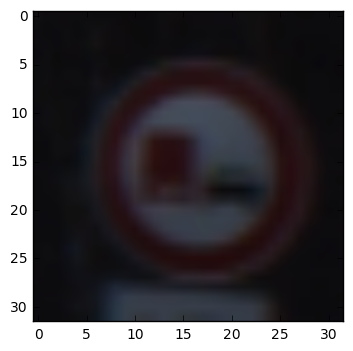

In [34]:
plt.imshow(current_X_train_batches[0][20] + 0.5)

In [117]:
sess.close()

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:**

In [ ]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In [ ]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

In [ ]:
### Train your model here.
### Feel free to use as many code cells as needed.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [35]:
import csv
from urllib import request as urllib
from PIL import Image
import io

In [36]:
sign_names = {}
with open('signnames.csv') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
         sign_names[row[0]] = row[1]

In [37]:
wiki_image_links = [\
              "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Zeichen_112_%E2%80%93_Unebene_Fahrbahn%2C_StVO_1970.svg/273px-Zeichen_112_%E2%80%93_Unebene_Fahrbahn%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e9/Zeichen_114_-_Schleudergefahr_bei_N%C3%A4sse_und_Schmutz%2C_StVO_1992.svg/273px-Zeichen_114_-_Schleudergefahr_bei_N%C3%A4sse_und_Schmutz%2C_StVO_1992.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/9/9e/Zeichen_112_%E2%80%93_Unebene_Fahrbahn%2C_StVO_1970.svg/273px-Zeichen_112_%E2%80%93_Unebene_Fahrbahn%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/8/87/Zeichen_276.svg/240px-Zeichen_276.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/3/39/Zeichen_278-56.svg/240px-Zeichen_278-56.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3b/Zeichen_281.svg/240px-Zeichen_281.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/0/09/Zeichen_280.svg/240px-Zeichen_280.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Zeichen_215_-_Kreisverkehr%2C_StVO_2000.svg/240px-Zeichen_215_-_Kreisverkehr%2C_StVO_2000.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/1/10/Zeichen_223_-_Links_vorbei%2C_StVO_1970.svg/240px-Zeichen_223_-_Links_vorbei%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8e/Zeichen_222_-_Rechts_vorbei%2C_StVO_1970.svg/240px-Zeichen_222_-_Rechts_vorbei%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/9/90/Zeichen_215_-_Geradeaus_und_links.svg/240px-Zeichen_215_-_Geradeaus_und_links.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/2/20/Zeichen_214_-_Geradeaus_und_rechts.svg/240px-Zeichen_214_-_Geradeaus_und_rechts.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/6/63/Zeichen_210_-_vorgeschriebene_Fahrtrichtung_%28links%29%2C_StVO_1970.svg/240px-Zeichen_210_-_vorgeschriebene_Fahrtrichtung_%28links%29%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bb/Zeichen_209_-_vorgeschriebene_Fahrtrichtung_%28rechts%29%2C_StVO_1970.svg/240px-Zeichen_209_-_vorgeschriebene_Fahrtrichtung_%28rechts%29%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/7/70/Zeichen_136-10_-_Kinder%2C_Aufstellung_rechts%2C_StVO_1992.svg/273px-Zeichen_136-10_-_Kinder%2C_Aufstellung_rechts%2C_StVO_1992.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/c6/Zeichen_133-10.svg/273px-Zeichen_133-10.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/9/93/Zeichen_131.svg/273px-Zeichen_131.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/3/3a/Zeichen_123.svg/273px-Zeichen_123.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Zeichen_121-10.svg/269px-Zeichen_121-10.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/5/58/Zeichen_105-20.svg/273px-Zeichen_105-20.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/8/8f/Zeichen_105-10.svg/273px-Zeichen_105-10.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/e0/Zeichen_103-20.svg/273px-Zeichen_103-20.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/a/a7/Zeichen_103-10.svg/273px-Zeichen_103-10.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/0/02/Zeichen_101_-_Gefahrstelle%2C_StVO_1970.svg/273px-Zeichen_101_-_Gefahrstelle%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/e/ee/Zeichen_267.svg/240px-Zeichen_267.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/7/72/Zeichen_253.svg/240px-Zeichen_253.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/b/bc/Zeichen_250.svg/240px-Zeichen_250.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/f/ff/Zeichen_306_-_Vorfahrtstra%C3%9Fe%2C_StVO_1970.svg/240px-Zeichen_306_-_Vorfahrtstra%C3%9Fe%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/2/2a/Zeichen_301_-_Vorfahrt%2C_StVO_1970.svg/269px-Zeichen_301_-_Vorfahrt%2C_StVO_1970.svg.png",\
                    "https://upload.wikimedia.org/wikipedia/commons/thumb/c/ca/Zeichen_277.svg/240px-Zeichen_277.svg.png"
             ]

In [38]:
from PIL import Image, ImageOps

wiki_images = []
for i in range(len(wiki_image_links)):
    fd = urllib.urlopen(wiki_image_links[i])
    image_file = io.BytesIO(fd.read())
    image = Image.open(image_file).convert('RGB')
    image = ImageOps.fit(image, (32,32), Image.ANTIALIAS)
    wiki_images.append( np.asarray(image, dtype=np.float32))
    
wiki_images = normalize(np.array(wiki_images))

22
Bumpy road


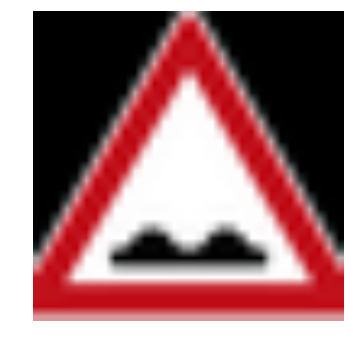

23
Slippery road


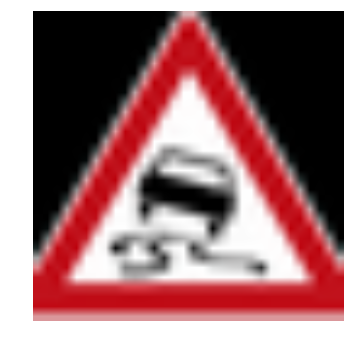

22
Bumpy road


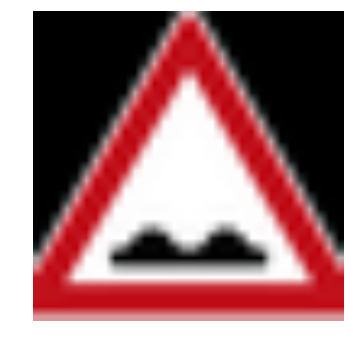

9
No passing


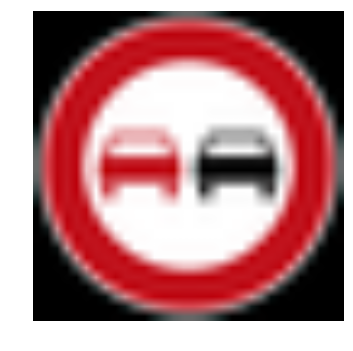

6
End of speed limit (80km/h)


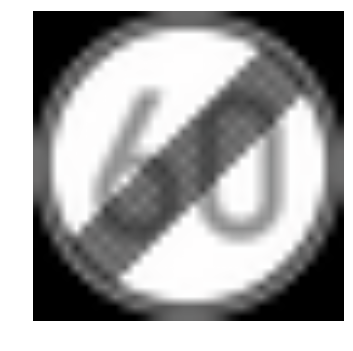

6
End of speed limit (80km/h)


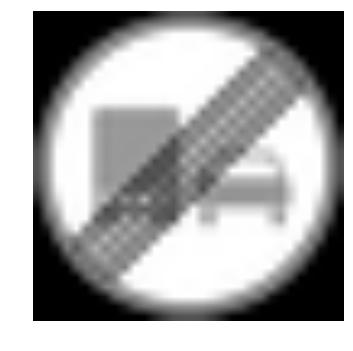

41
End of no passing


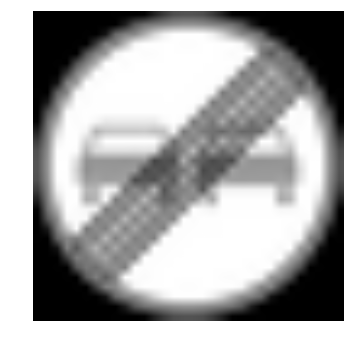

40
Roundabout mandatory


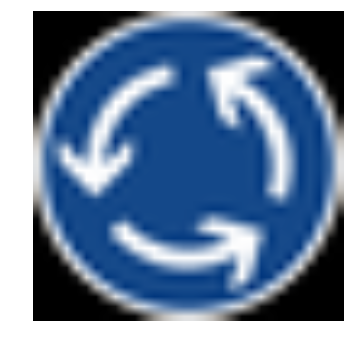

39
Keep left


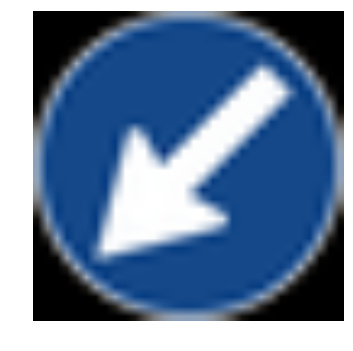

38
Keep right


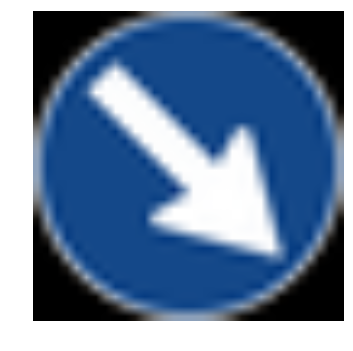

37
Go straight or left


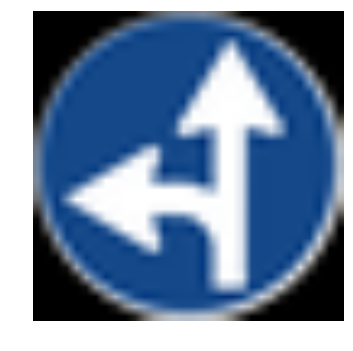

36
Go straight or right


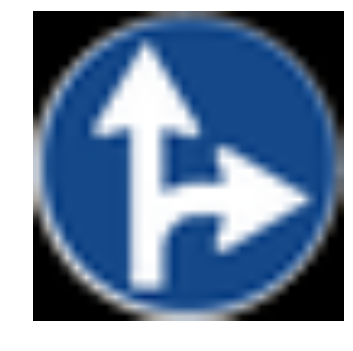

34
Turn left ahead


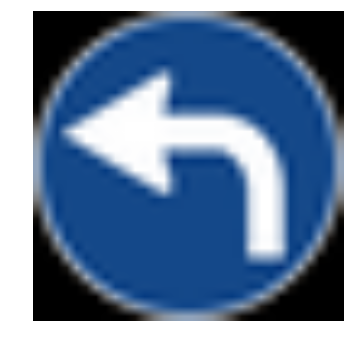

33
Turn right ahead


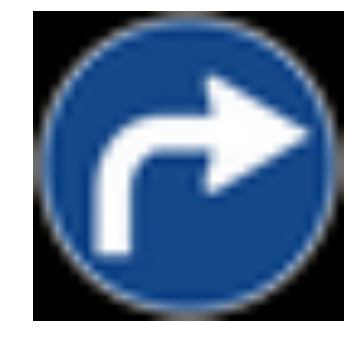

28
Children crossing


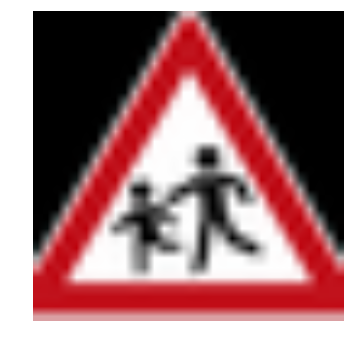

27
Pedestrians


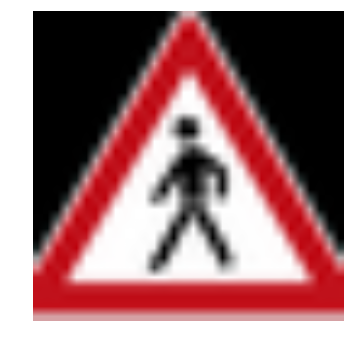

26
Traffic signals


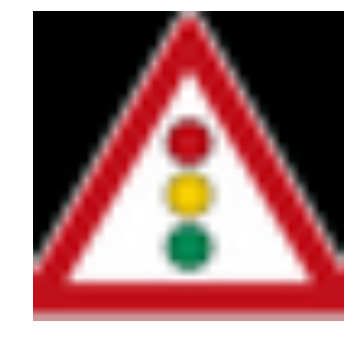

25
Road work


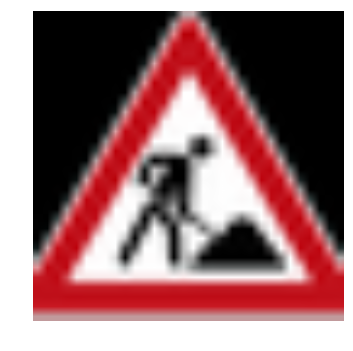

24
Road narrows on the right


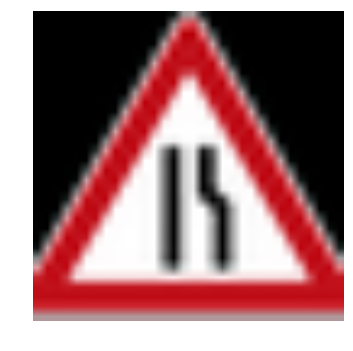

28
Children crossing


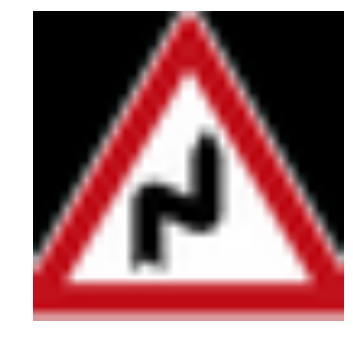

21
Double curve


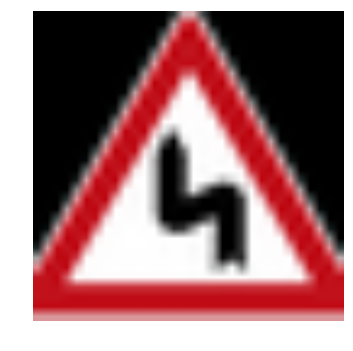

23
Slippery road


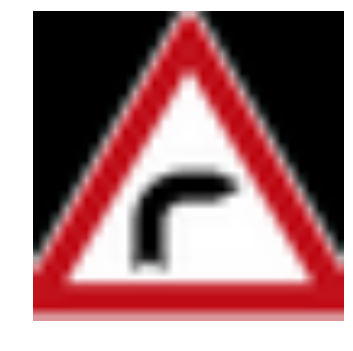

19
Dangerous curve to the left


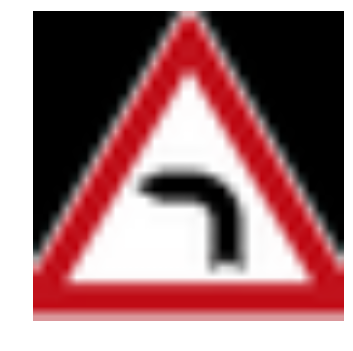

18
General caution


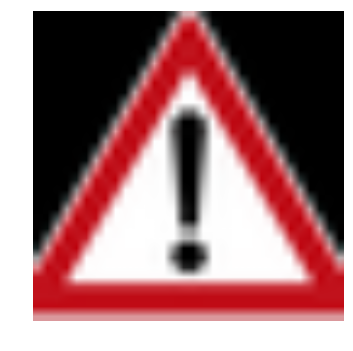

17
No entry


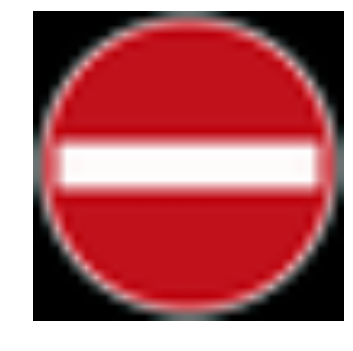

16
Vechiles over 3.5 metric tons prohibited


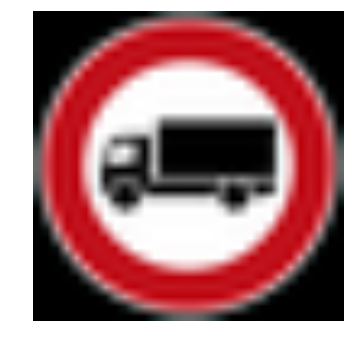

15
No vechiles


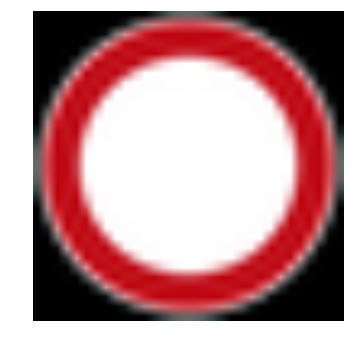

12
Priority road


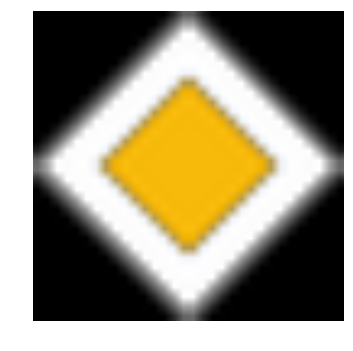

11
Right-of-way at the next intersection


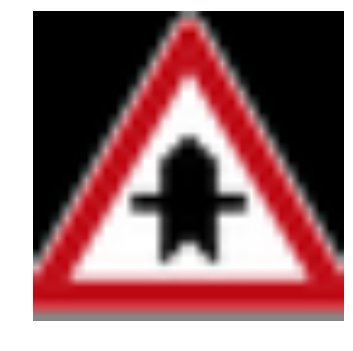

10
No passing for vechiles over 3.5 metric tons


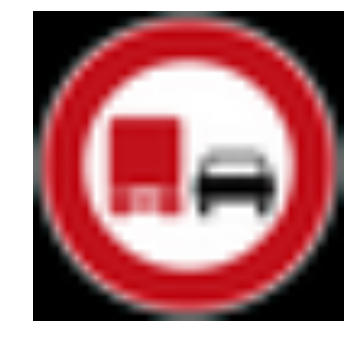

In [39]:
for img in wiki_images:
    sign_prediction = sess.run(prediction, feed_dict={x:[img], keep_prob: 1.})
    plt.axis('off')
    plt.imshow(img+0.5)
    print(np.argmax(sign_prediction))
    print(sign_names[str(np.argmax(sign_prediction))])
    plt.show()




______________________________
Road work


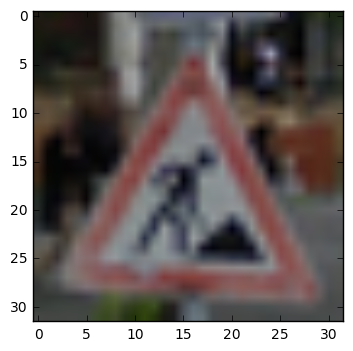

1:  Road work
2:  Children crossing
3:  Bumpy road
4:  Road narrows on the right
5:  Pedestrians


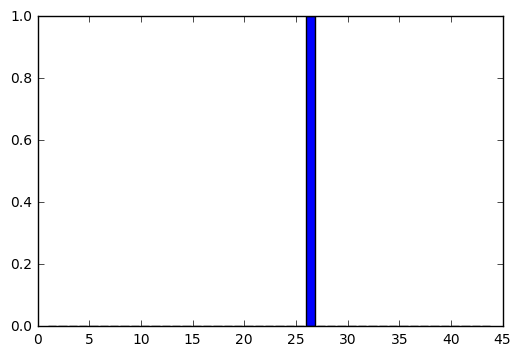




______________________________
Go straight or right


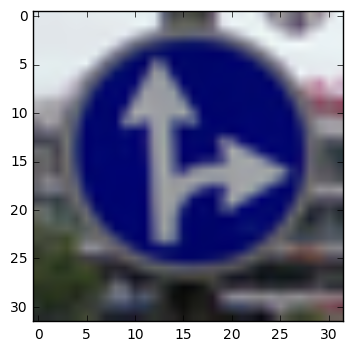

1:  Go straight or right
2:  Ahead only
3:  Keep right
4:  Roundabout mandatory
5:  Turn right ahead


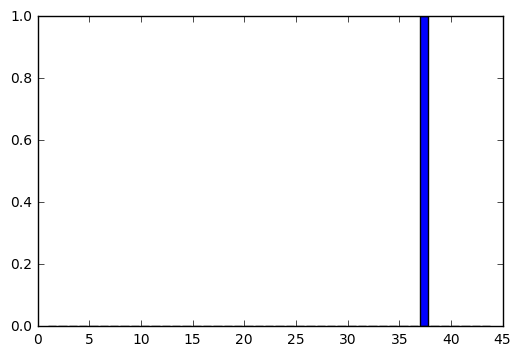




______________________________
Yield


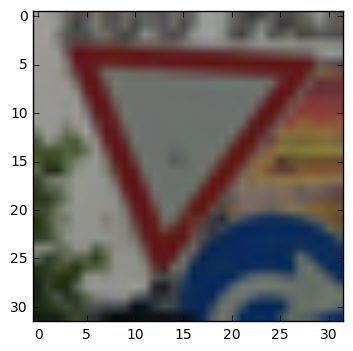

1:  Yield
2:  No passing
3:  Priority road
4:  Speed limit (20km/h)
5:  Speed limit (30km/h)


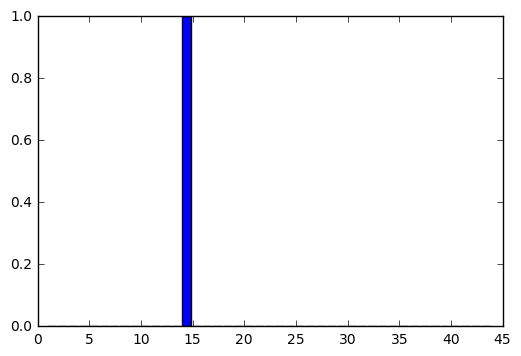




______________________________
Turn right ahead


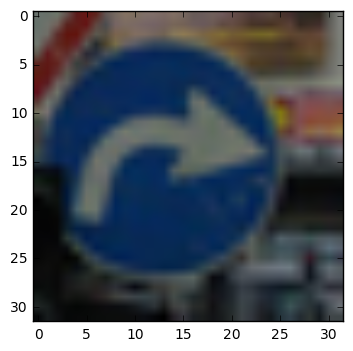

1:  Turn right ahead
2:  Ahead only
3:  Roundabout mandatory
4:  Go straight or left
5:  Turn left ahead


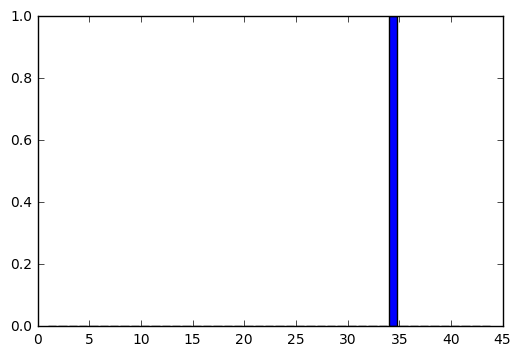




______________________________
Keep right


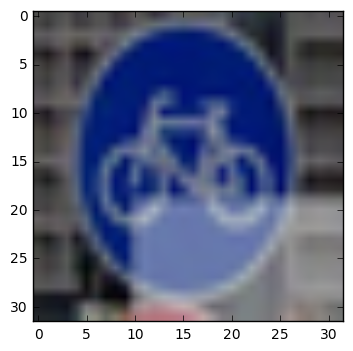

1:  Keep right
2:  Keep left
3:  Roundabout mandatory
4:  Go straight or left
5:  Turn right ahead


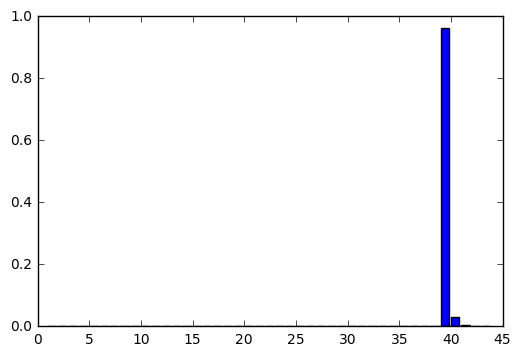




______________________________
Road narrows on the right


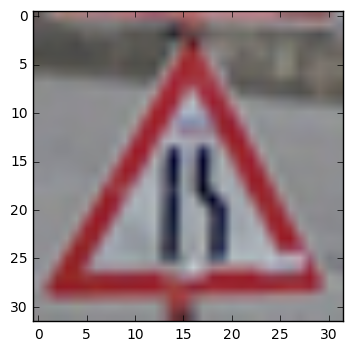

1:  Road narrows on the right
2:  Pedestrians
3:  General caution
4:  Children crossing
5:  Right-of-way at the next intersection


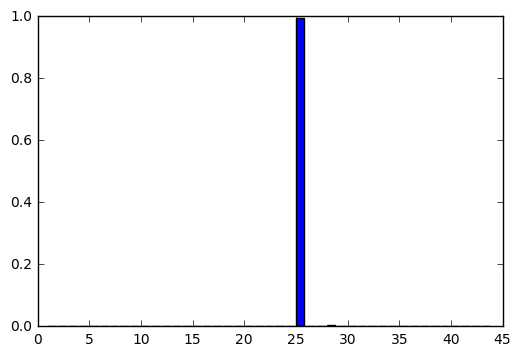




______________________________
Ahead only


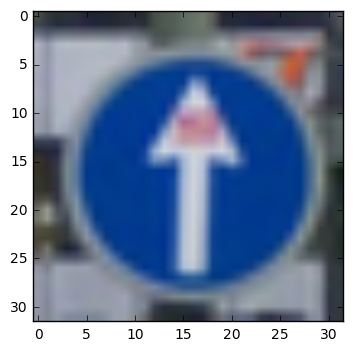

1:  Ahead only
2:  Turn left ahead
3:  Go straight or left
4:  Go straight or right
5:  Turn right ahead


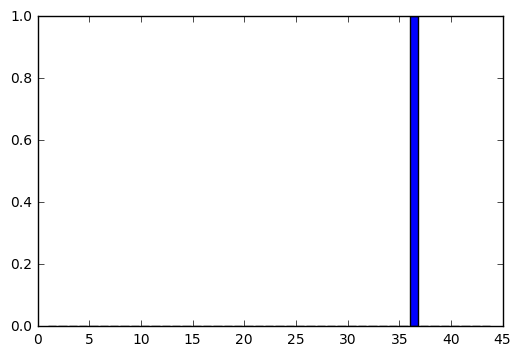




______________________________
Go straight or right


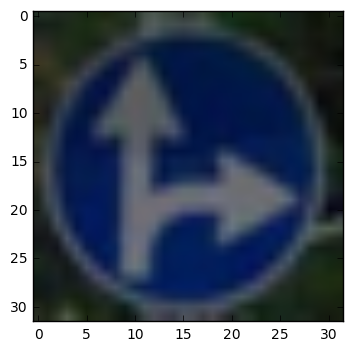

1:  Go straight or right
2:  Keep right
3:  Roundabout mandatory
4:  Turn left ahead
5:  Turn right ahead


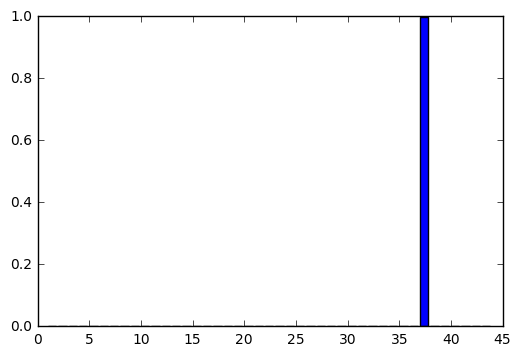




______________________________
Priority road


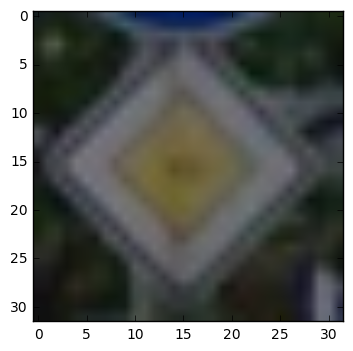

1:  Priority road
2:  Yield
3:  End of speed limit (80km/h)
4:  End of all speed and passing limits
5:  Traffic signals


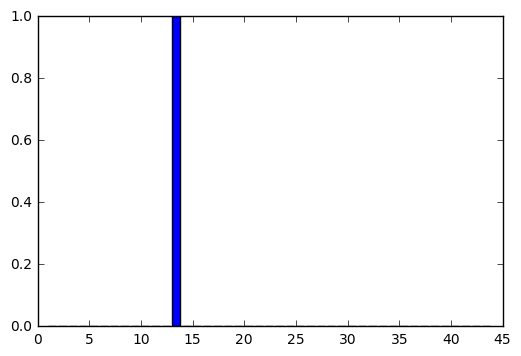




______________________________
Roundabout mandatory


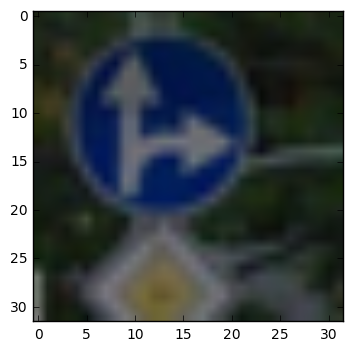

1:  Roundabout mandatory
2:  Turn left ahead
3:  Keep right
4:  Go straight or right
5:  Go straight or left


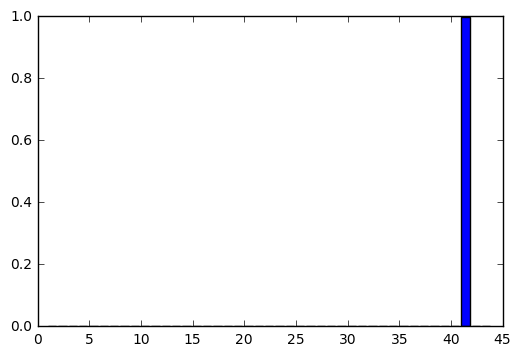

In [40]:
raw_images =[Image.open("./Breitscheidplatz/sign1.png"), \
            Image.open("./Breitscheidplatz/sign2.png"), \
            Image.open("./Breitscheidplatz/sign3.png"), \
            Image.open("./Breitscheidplatz/sign4.png"), \
            Image.open("./Breitscheidplatz/sign5.png"), \
            Image.open("./Breitscheidplatz/sign6.png"), \
            Image.open("./Breitscheidplatz/sign7.png"), \
            Image.open("./Breitscheidplatz/sign8.png"), \
            Image.open("./Breitscheidplatz/sign9.png"), \
            Image.open("./Breitscheidplatz/sign10.png")]

maximilaneum_signs = []
images = []
for image in raw_images:
    images.append(np.asarray(ImageOps.fit(image, (32,32), Image.ANTIALIAS)))

images = normalize(np.array(images, dtype=np.float32))

for image in images:
    class_oh = sess.run(prediction, feed_dict={x:[image], keep_prob: 1.})
    sign = sign_names[str(np.argmax(class_oh))]
    
    print("\n\n\n______________________________")
    
    print(sign)
    plt.imshow(image + 0.5)
    plt.show()
    
    top5 = tf.nn.top_k(prediction, k=5, sorted=True, name=None)
    count = 1
    for i in sess.run(top5, feed_dict={x:[image], keep_prob:1.}).indices[0]:
        print(str(count)+":  "+sign_names[str(i)])
        count = count+1
        
    fig = plt.figure()
    plt.bar( np.arange(1, 44), class_oh[0])
    plt.show()
    
    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**

In [41]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

<font color='red'>
One would expect the model to perform slightly worse on the new images than those from the set it was trained on, simply because it's an entirely different datasource taken with a different camera, and from entirely different angles (My candidate images were taken from Google StreetView, which means the camera was mounted on top of the car, and we would expect the images to be much more distorted than those from a front-mounted, standard camera).
<br><br>
However, the model performed well and seems to have learned the features of the traffic signs (and not the subtle condition differences), which is great.  I validated this by also using a standard online sign dataset (which contains no distortion and no "outside effects") and still the model performed well, correctly classifying each of the images. This tells us that the model was able to capture the features of the traffic signs and not overfit (too severely) to the data it was trained with.
</font> 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.